In [2]:
import numpy as np
inf=float("inf")

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.stats as st

import stablerank.srank as sr
import stablerank.geometry_objects_2020 as ge

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import _pickle as pickle

from ripser import ripser
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from PIL import Image

#from keras.datasets import mnist
#from matplotlib import pyplot

### Import Data

In [3]:
# loading the data

df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv', sep=',')
#df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv', sep=',',header=None)

In [4]:
# Removing duplicate values and reindexing

df.drop_duplicates(subset =[" pixels"], inplace = True)
df=df.reindex(range(0,len(df)-1))

In [4]:
# Inspecting the Dataframe

df

,emotion,Usage,pixels
0,0.0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0.0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2.0,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4.0,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6.0,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
34028,0.0,PrivateTest,157 157 157 157 156 156 155 155 157 155 155 14...
34029,3.0,PrivateTest,24 33 41 48 48 58 75 95 110 139 158 172 178 18...
34030,5.0,PrivateTest,42 70 65 49 34 33 34 39 58 61 86 86 68 93 76 5...
34031,0.0,PrivateTest,49 47 51 60 60 61 66 70 74 74 70 63 65 75 69 6...


[231 212 156 ...  88 110 152]
[[231 212 156 ...  44  27  16]
 [229 175 148 ...  27  35  27]
 [214 156 157 ...  28  22  28]
 ...
 [241 245 250 ...  57 101 146]
 [246 250 252 ...  78 105 162]
 [250 251 250 ...  88 110 152]]


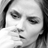

In [50]:
# Printing the first picture
first_picture = [int(numeric_string) for numeric_string in df[" pixels"][2].split(' ')]
first_picture_arr = np.array(first_picture)
print(first_picture_arr)
first_picture_arr.resize((48,48))
print(first_picture_arr)
im = Image.fromarray((first_picture_arr).astype(np.uint8))
#im = Image.fromarray((255-first_picture_arr* 255).astype(np.uint8))
im


## Try filters

In [10]:
cv.imread?

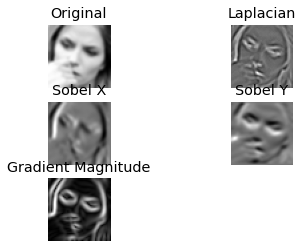

In [51]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = (first_picture_arr).astype(np.uint8)
img = cv.GaussianBlur(img,(3,3),0)
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)

gradient_magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
 
gradient_magnitude *= 255.0 / gradient_magnitude.max()

plt.subplot(3,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,5),plt.imshow(gradient_magnitude,cmap = 'gray')
plt.title('Gradient Magnitude'), plt.xticks([]), plt.yticks([])
plt.show()

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]]


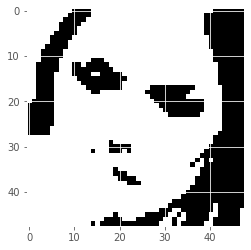

In [55]:
from skimage.filters import threshold_otsu
#img = (first_picture_arr).astype(np.uint8)
bw_img = (img >= threshold_otsu(img))
print(bw_img)

plt.imshow(bw_img,cmap='gray')

In [27]:
print(laplacian)

[[ 62. -47. -15. ...  23.  -8.   8.]
 [ 29. -26.  -4. ...  23.   1. -22.]
 [ 18.  23. -47. ...  26. -12. -13.]
 ...
 [-71.  29. -25. ...  82. -34. -50.]
 [-44.  20. -24. ...  39. -37. -53.]
 [-40. -18.   9. ... -14. -42.  -6.]]


## $H_0$ Stable Ranks for Embedding 2

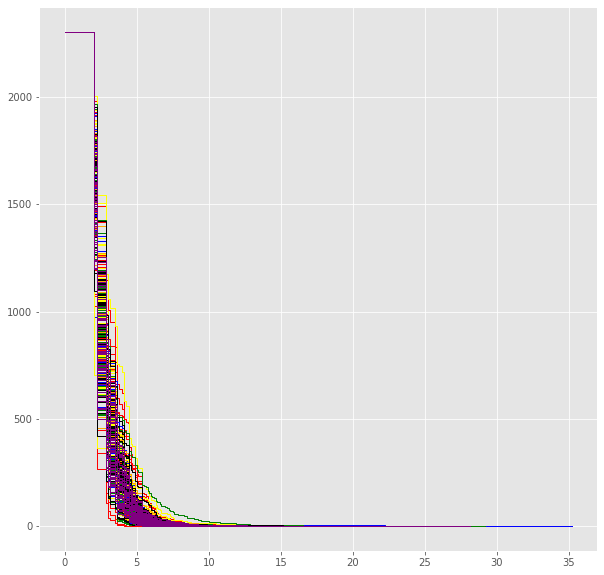

In [62]:
def getLaplacianFiltered(x):
    first_picture_arr = np.array(x)
    first_picture_arr.resize((48,48))
    img = (first_picture_arr).astype(np.uint8)
    img = cv.GaussianBlur(img,(3,3),0)
    laplacian = cv.Laplacian(img,cv.CV_64F)
    x = np.resize(laplacian,(48*48))
    return x

def getSobelFiltered(x):
    first_picture_arr = np.array(x)
    first_picture_arr.resize((48,48))
    img = (first_picture_arr).astype(np.uint8)
    img = cv.GaussianBlur(img,(3,3),0)
    sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
    sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
    gradient_magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
    x = np.resize(gradient_magnitude,(48*48))
    return x


emotion_categories = [0,1,2,3,4,5,6]
#emotion_categories = [1,6]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]

# specifying the number of pictures for subsampling
number_of_pictures = 50# How many pictures per subsampling

# specifying metric
metric = "euclidean"
metric_parameter = None

# specifying clustering method
clustering_method = "average"

plt.figure(figsize=(10,10))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    #rand_pos=pos
    
    # Calculate euclidean object for the first image
    pixel_values_1 = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[0]].split(' ')]
    
    ##apply filter
    pixel_values_1 = getLaplacianFiltered(pixel_values_1)
    

    image_dummy_1 = np.empty((48*48,3), int)
    
    for i in range(0,len(image_dummy_1)):
        # Try out different normalizations:
        # No normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, pixel_values_1[i]/255]
        # Normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, 47*pixel_values_1[i]/255]
        # Fully normalized
        # image_dummy_1[i] = [((i-i%48)/48)/47, (i%48)/47, pixel_values_1[i]/255]
        
        # Working best: All values between 0 and 100
        image_dummy_1[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]
        
    image_stacked_1 = np.vstack(image_dummy_1)
    image_1 = sr.EucObject(image_stacked_1)
    
    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    f = image_1.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
    
    
    # Calculate stable rank for the remaining images
    for p in range(0,number_of_pictures):
        
        pixel_values_i = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[p]].split(' ')]

        ##apply filter
        pixel_values_i = getLaplacianFiltered(pixel_values_i)
        
        image_dummy_i = np.empty((48*48,3), int)
        
        for i in range(0,len(image_dummy_i)):
            image_dummy_i[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_i[i]/255)]

        image_stacked_i = np.vstack(image_dummy_i)
        image_i = sr.EucObject(image_stacked_i)
        
        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        # f = f + image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
        
        # Plot single pcf
        f = image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)
        f.plot(color=colours[emotion_categories.index(e)])
    
    # plot the average pcf
    #f.plot(color=colours[emotion_categories.index(e)])

## $H_1$ Stable Ranks for Embedding 2

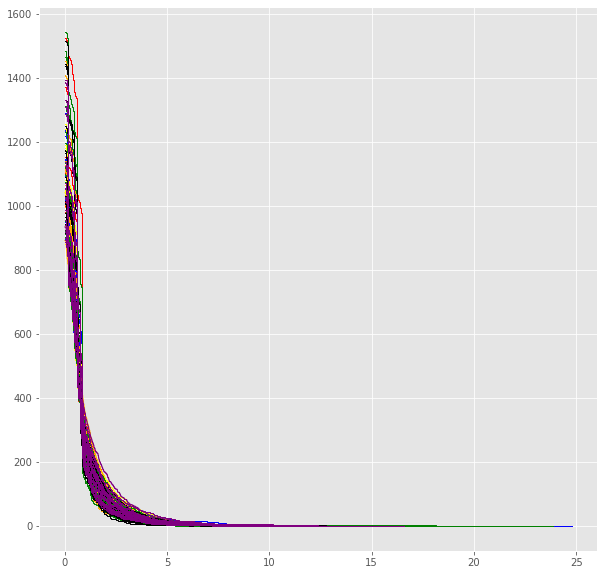

In [67]:

emotion_categories = [0,1,2,3,4,5,6]
#emotion_categories = [1,5]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]

# specifying the number of pictures for subsampling
number_of_pictures = 20# How many pictures per subsampling

# specifying metric
metric = "euclidean"
metric_parameter = None

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(10,10))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    #rand_pos=pos
    
    # Calculate euclidean object for the first image
    pixel_values_1 = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[0]].split(' ')]
    
    ##apply filter
    #pixel_values_1 = getLaplacianFiltered(pixel_values_1)
    

    image_dummy_1 = np.empty((48*48,3), int)
    
    for i in range(0,len(image_dummy_1)):
        # Try out different normalizations:
        # No normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, pixel_values_1[i]/255]
        # Normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, 47*pixel_values_1[i]/255]
        # Fully normalized
        # image_dummy_1[i] = [((i-i%48)/48)/47, (i%48)/47, pixel_values_1[i]/255]
        
        # Working best: All values between 0 and 100
        image_dummy_1[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]
        
    image_stacked_1 = np.vstack(image_dummy_1)
    image_1 = sr.EucObject(image_stacked_1)
    
    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    f = image_1.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
    
    
    # Calculate stable rank for the remaining images
    for p in range(0,number_of_pictures):
        
        pixel_values_i = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[p]].split(' ')]

        ##apply filter
        #pixel_values_i = getLaplacianFiltered(pixel_values_i)
        
        image_dummy_i = np.empty((48*48,3), int)
        
        for i in range(0,len(image_dummy_i)):
            image_dummy_i[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_i[i]/255)]

        image_stacked_i = np.vstack(image_dummy_i)
        image_i = sr.EucObject(image_stacked_i)
        
        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        # f = f + image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
        
        # Plot single pcf
        bar_code = image_i.get_bc(metric = metric, metric_parameter = metric_parameter)
        f = sr.bc_to_sr(bar_code, degree="H1")
        f.plot(color=colours[emotion_categories.index(e)])
    
    # plot the average pcf
    #f.plot(color=colours[emotion_categories.index(e)])